## Part 1: The Ideal Case

### 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# We will use the kinematic formula, assuming no intial
# velocity, and assuming that g is constant (since 4 km is small
# compared to 6378 km, the Earth's radius).

g = 9.81 # g factor from lab paper
delta_y = 4000 # height of mine

t_fall_analytic = np.sqrt((2*delta_y)/(g))
print(f"Analytic fall time: {t_fall_analytic} s")

Analytic fall time: 28.55686245854129 s


### 2.

The time it takes to fall to the bottom is: 28.55686245854129 s.
This agrees with the analytic calculation.


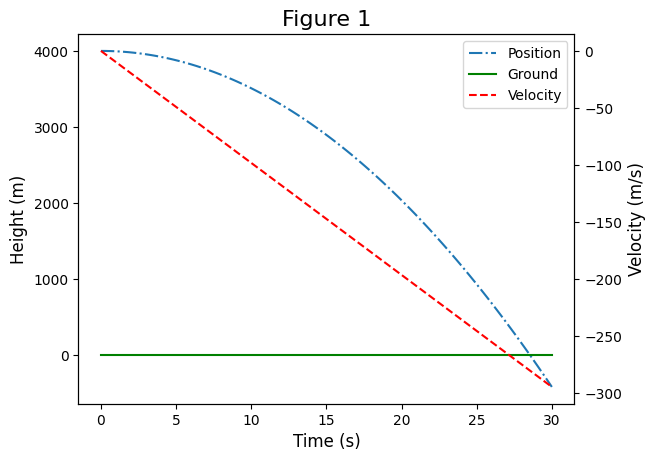

In [2]:
def derivatives(t,s):
    y,v = s # y is the position, v is velocity
    dydt = v 
    dvdt = -g
    return [dydt, dvdt]

def stopping(t,s):
    return s[0] 


t0, tf = (0,30) # go past 28 to include when it hits the bottom

t_eval = np.linspace(t0,tf, 100)

y0 = [4000,0] # technically 0, but height is relative

soln = solve_ivp(fun = derivatives, t_span = (t0,tf), y0 = y0, t_eval = t_eval, events = stopping)


t = soln.t
y = soln.y[0]
v = soln.y[1]
zeros = np.zeros(len(t)) # y-coordinates for line at 0

fig, ax = plt.subplots()

ax.plot(t,y, ls = '-.', label = "Position")
ax.set_ylabel("Height (m)", fontsize = 12)
ax.set_xlabel("Time (s)", fontsize = 12)
ax.plot(t, zeros, color = 'green', label = "Ground")

ax2 = ax.twinx()

ax2.plot(t,v, color = 'red', ls = '--', label = "Velocity")
ax2.set_ylabel("Velocity (m/s)",fontsize = 12)
ax.set_title("Figure 1", fontsize = 16)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.savefig('Fig1.png')

simple_time = soln.t_events[0][0]
print(f"The time it takes to fall to the bottom is: {soln.t_events[0][0]} s.")
print(f"This agrees with the analytic calculation.")

## Part 2: Including drag and a variable $g$

The time it takes to fall to the bottom is: 28.558355111904834 s.
The height-dependent g increases the fall time by 0.0014926533635453154 s, which is negligible.


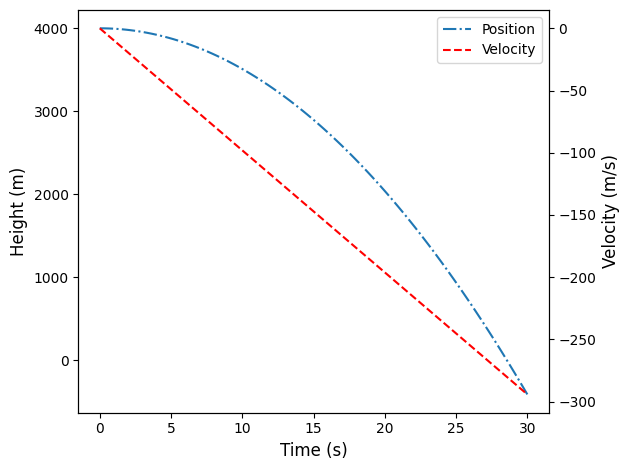

In [3]:
earth_rad = 6378.1E3 # earth radius

def derivatives(t,s):
    y,v = s # y is the position, v is velocity
    dydt = v 
    dvdt = -g*(y/earth_rad) # new force depends on y
    return [dydt, dvdt]

def stopping(t,s):
    return s[0] - earth_rad + 4000 


t0, tf = (0,30) # go past 28 to include when it hits the bottom

t_eval = np.linspace(t0,tf, 100)

y0 = [earth_rad,0]

soln = solve_ivp(fun = derivatives, t_span = (t0,tf), y0 = y0, t_eval = t_eval, events = stopping)

t = soln.t
y = soln.y[0]
v = soln.y[1]
zeros = np.zeros(len(t)) # y-coordinates for line at 0

relative_height = y - earth_rad + 4000 # height above the mineshaft

fig, ax  = plt.subplots()

ax.plot(t,relative_height, ls = '-.', label = "Position")
ax.set_xlabel("Time (s)", fontsize = 12)
ax.set_ylabel("Height (m)", fontsize = 12)
ax2 = ax.twinx()
ax2.plot(t,v, color = 'red', ls = '--', label = "Velocity")
ax2.set_ylabel("Velocity (m/s)", fontsize = 12)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

fig.tight_layout()
plt.savefig('Fig2.png')


print(f"The time it takes to fall to the bottom is: {soln.t_events[0][0]} s.")
print(f"The height-dependent g increases the fall time by {soln.t_events[0][0] - simple_time} s, which is negligible.")

### Incorporating air-drag

The time it takes to fall to the bottom is: 83.54308278263785 s.
The fall time is increased by 54.986220324096564 s, which is huge.


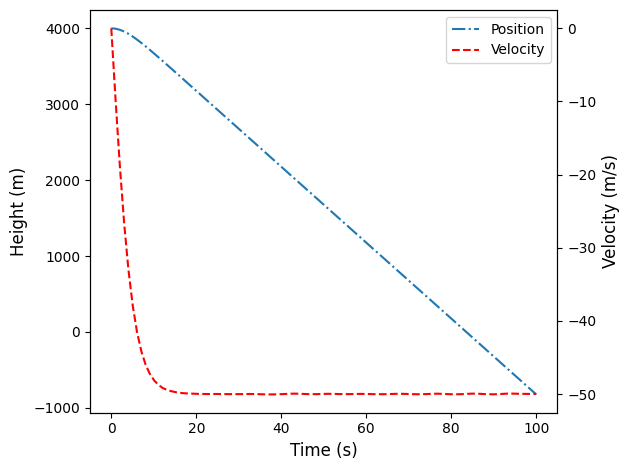

In [4]:
# alpha = -g/(v_ter)^2, which we can find by setting 
# F = 0, and v = v_ter (since forces equalize at terminal
# velocity).
v_ter = 50  # terminal velocity of mass
alpha = -g/(v_ter**2) # drag coefficient

earth_rad = 6378.1E3

def derivatives(t,s):
    y,v = s # y is the position, v is velocity
    dydt = v 
    dvdt = -g*(y/earth_rad) - alpha*(v**2) # new force depends on y and v
    return [dydt, dvdt]

def stopping(t,s):
    return s[0] - earth_rad + 4000 # when y hits the bottom


t0, tf = (0,100) # go far past 28 to include when it hits the bottom

t_eval = np.linspace(t0,tf, 100)

y0 = [earth_rad,0]

soln = solve_ivp(fun = derivatives, t_span = (t0,tf), y0 = y0, t_eval = t_eval, events = stopping)

t = soln.t
y = soln.y[0]
v = soln.y[1]
zeros = np.zeros(len(t)) # y-coordinates for line at 0

relative_height = y - earth_rad + 4000 # height above the mineshaft

fig, ax  = plt.subplots()

ax.plot(t,relative_height, ls = '-.', label = "Position")
ax.set_xlabel("Time (s)", fontsize = 12)
ax.set_ylabel("Height (m)", fontsize = 12)
ax2 = ax.twinx()
ax2.plot(t,v, color = 'red', ls = '--', label = "Velocity")
ax2.set_ylabel("Velocity (m/s)", fontsize = 12)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
fig.tight_layout()

print(f"The time it takes to fall to the bottom is: {soln.t_events[0][0]} s.")
print(f"The fall time is increased by {soln.t_events[0][0] - simple_time} s, which is huge.")

## Part 3: The Coriolis Force

### 1-3

The test mass bumps into the wall 1646.1335087409243 m before reaching the bottom, at time 21.907102918964984 s.


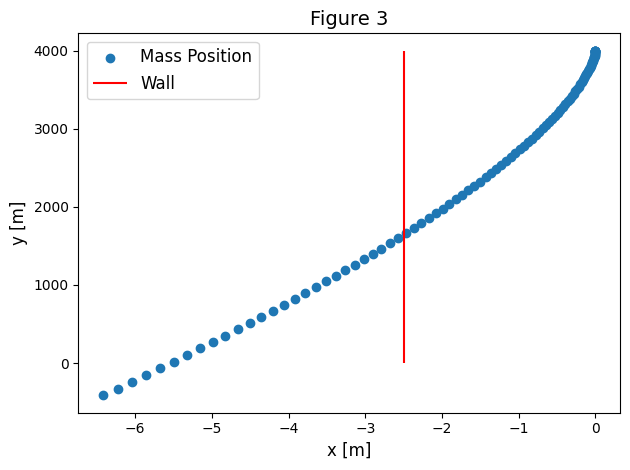

In [5]:
omega = 7.272E-5 # Earth rotation vector
alpha = 0 # we are turning drag off

# Note: we need not track z, since Fz = 0, vz = 0 
# => the z position will never change

def derivatives(t,s):
    x,y,vx,vy = s # y is the position, vy is y-velocity, likewise for x,vx
    dydt = vy 
    dvydt = -g*(y/earth_rad) - alpha*(vy**2) -2*omega*vx
    dxdt = vx
    dvxdt = 2*omega*vy
    return [dxdt, dydt, dvxdt, dvydt]

def stopping(t,s):
    return s[0] + 2.5 # when x = -2.5, so when it hits the left wall


t0, tf = (0,30) # go past 28 to include when it hits the bottom

t_eval = np.linspace(t0,tf, 100)

y0 = [0, earth_rad,0, 0]

soln = solve_ivp(fun = derivatives, t_span = (t0,tf), y0 = y0, t_eval = t_eval, events = stopping)

t = soln.t
x = soln.y[0]
y = soln.y[1]
vx = soln.y[2]
vy = soln.y[3]

relative_height = y - earth_rad + 4000 # height above the mineshaft

fig, ax  = plt.subplots()
ax.scatter(x, relative_height, label = "Mass Position")
ax.set_title("Figure 3", fontsize = 14)
ax.set_xlabel("x [m]", fontsize = 12)
ax.set_ylabel("y [m]", fontsize = 12)
ax.vlines(-2.5, 0, 4000, color = 'red', label = "Wall")
ax.legend(fontsize = 12)

fig.tight_layout()
plt.savefig('Fig3.png')

print(f"The test mass bumps into the wall {(soln.y_events[0][0][1] - earth_rad + 4000)} m before reaching the bottom, at time {soln.t_events[0][0]} s.")

### 4.

With air drag, the mass now bumps into the wall 2697.461605645716 m before reaching the bottom. So drag does make a difference, since the collision happens much higher up. Time is 29.58329253066612 s.


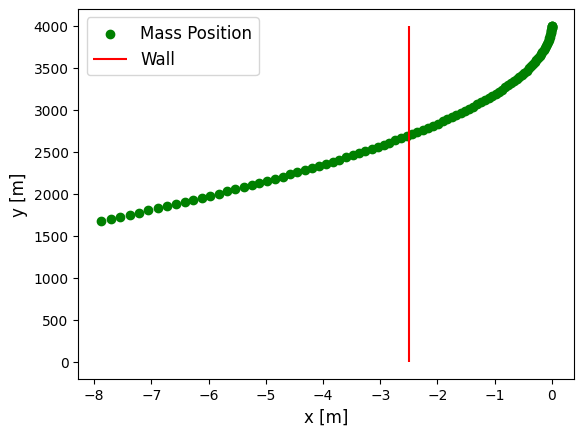

In [6]:
omega = 7.272E-5 # Earth rotation vector
v_ter = 50 # mass terminal velocity
alpha = -g/(v_ter**2)  # drag coefficient, turning drag on again

# Note: we need not track z, since Fz = 0, vz = 0 
# => the z position will never change

def derivatives(t,s):
    x,y,vx,vy = s # y is the position, v is velocity
    dydt = vy 
    dvydt = -g*(y/earth_rad) - alpha*(vy**2) -2*omega*vx
    dxdt = vx
    dvxdt = 2*omega*vy
    return [dxdt, dydt, dvxdt, dvydt]

def stopping(t,s):
    return s[0] + 2.5


t0, tf = (0,50) # go past 28 to include when it hits the bottom

t_eval = np.linspace(t0,tf, 100)

y0 = [0, earth_rad,0, 0]

soln = solve_ivp(fun = derivatives, t_span = (t0,tf), y0 = y0, t_eval = t_eval, events = stopping)

t = soln.t
x = soln.y[0]
y = soln.y[1]
vx = soln.y[2]
vy = soln.y[3]

relative_height = y - earth_rad + 4000 # height above the mineshaft

fig, ax  = plt.subplots()
ax.scatter(x, relative_height, color = 'green', label = "Mass Position")
ax.set_xlabel("x [m]", fontsize = 12)
ax.set_ylabel("y [m]", fontsize = 12)
ax.vlines(-2.5, 0, 4000, color = 'red', label = "Wall")
ax.legend(fontsize = 12)

print(f"With air drag, the mass now bumps into the wall {(soln.y_events[0][0][1] - earth_rad + 4000)} m before reaching the bottom. So drag does make a difference, since the collision happens much higher up. Time is {soln.t_events[0][0]} s.")

## Part 4: An infinitely deep mine

The plot shows that both position and velocity are sinusoidal and periodic, as well as phase-shifted relative to one another.
It takes 1266.473 s to reach the center, at speed 7910.760 m/s.
The Earth's orbital period is: 5069.371199675785 s
The ratio between the orbital period and crossing time is: 4.00274567254993
This makes sense, since the mass needs to make the equivalent of 4 crossing journeys to get back to the original point.


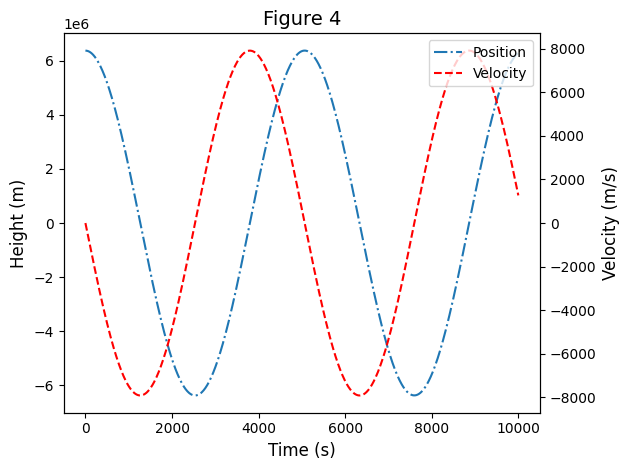

In [7]:
import scipy
earth_rad = 6378.1E3 # Earth radius
earth_mass = 5.972E24 # Earth mass

def derivatives(t,s):
    y,v = s # y is the position, v is velocity
    dydt = v 
    dvdt = -g*(y/earth_rad) # new force depends on y
    return [dydt, dvdt]

def stopping(t,s):
    return s[0] # now we are using absolute depth, so no need for relative


t0, tf = (0,10000) # go to 10000 to capture many cycles

t_eval = np.linspace(t0,tf, 1000)

y0 = [earth_rad,0]

soln = solve_ivp(fun = derivatives, t_span = (t0,tf), y0 = y0, t_eval = t_eval, events = stopping)

t = soln.t
y = soln.y[0]
v = soln.y[1]

fig, ax  = plt.subplots()

ax.plot(t,y, ls = '-.', label = "Position")
ax.set_xlabel("Time (s)", fontsize = 12)
ax.set_ylabel("Height (m)", fontsize = 12)
ax2 = ax.twinx()
ax2.plot(t,v, color = 'red', ls = '--', label = "Velocity")
ax2.set_ylabel("Velocity (m/s)", fontsize = 12)
ax.set_title("Figure 4", fontsize = 14)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

fig.tight_layout()
plt.savefig('Fig4.png')

print(f"The plot shows that both position and velocity are sinusoidal and periodic, as well as phase-shifted relative to one another.")


print(f"It takes {soln.t_events[0][0]:.3f} s to reach the center, at speed {np.abs(soln.y_events[0][0][1]):.3f} m/s.")

v_orbital = np.sqrt(scipy.constants.G*earth_mass/earth_rad) # from classical mech

T_orbital = (2*np.pi*earth_rad)/v_orbital # T = 2piR/v

print(f"The Earth's orbital period is: {T_orbital} s")
print(f"The ratio between the orbital period and crossing time is: {T_orbital/(soln.t_events[0][0])}")
print(f"This makes sense, since the mass needs to make the equivalent of 4 crossing journeys to get back to the original point.")

## Part 5: A non-uniform Earth

### 1.

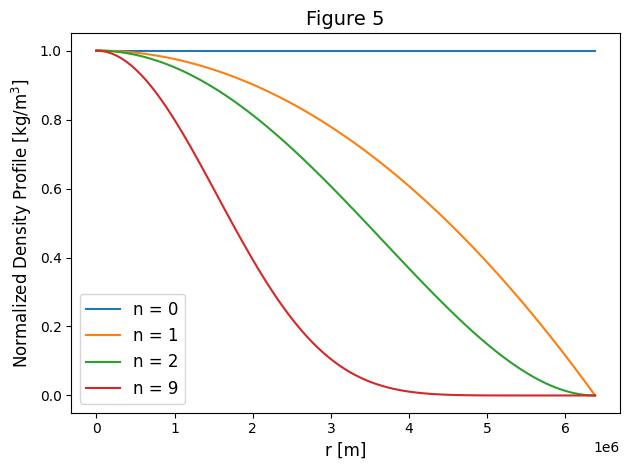

In [8]:
from scipy.integrate import quad

n_vals = [0,1,2,9] # array of n values



def density_prof(r, n):
        return (1-r**2/earth_rad**2)**n # function of r and n

r_vals = np.linspace(1,earth_rad,100) # array of radii from 1m to earth_rad, avoids division by 0

fig, ax = plt.subplots()

for i in range(len(n_vals)):
    ax.plot(r_vals,density_prof(r_vals, n_vals[i]), label = f"n = {n_vals[i]}") # iterating plot over n values

ax.set_xlabel("r [m]", fontsize = 12)
ax.set_ylabel("Normalized Density Profile [kg/m$^3$]", fontsize = 12)
ax.set_title("Figure 5", fontsize = 14)
ax.legend(fontsize = 12)
fig.tight_layout()
plt.savefig('Fig5.png')

def integrand(r,n):
    return r**2*(1-r**2/earth_rad**2)**n # need r^2 to do integral in sph coords

def density_normalizer(n):
    mass, err = quad(integrand, 0, earth_rad, args = (n,)) # function of n, finds normalization
    norm = earth_mass/(mass)
    return norm


def g_force(R,n):
    norm = density_normalizer(n)
    mass_enclosed_unnorm, err = quad(integrand, 0, R, args = (n,)) # finds enclosed mass as a function
    mass_enclosed = norm*mass_enclosed_unnorm                      # of r, and uses that to get g force
    force = scipy.constants.G*mass_enclosed/(R**2)
    return force



### 2.

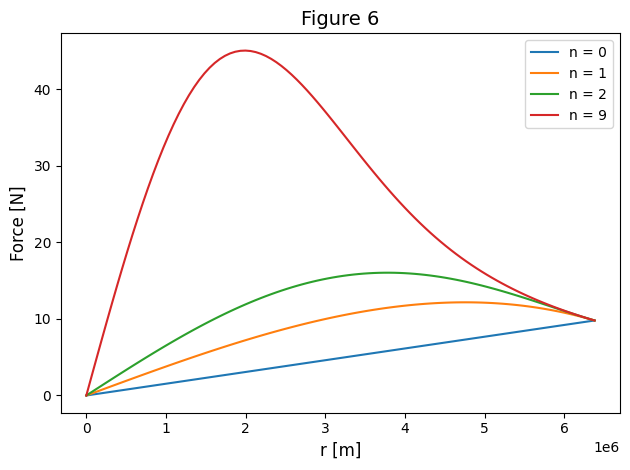

In [9]:
fig, ax = plt.subplots()

def force_profile(r, n):  # iterates over n vals to find respective g forces
    force_vals = []
    for i in range(len(r)):
        force = g_force(r[i], n)
        force_vals.append(force)
    return force_vals  

for i in range(len(n_vals)): # iterates over n vals to plot force profile
    ax.plot(r_vals, force_profile(r_vals, n_vals[i]), label = f"n = {n_vals[i]}")

ax.legend()
ax.set_xlabel('r [m]', fontsize = 12)
ax.set_ylabel("Force [N]", fontsize = 12)
ax.set_title("Figure 6", fontsize = 14)
fig.tight_layout()
plt.savefig('Fig6.png')

### 3.

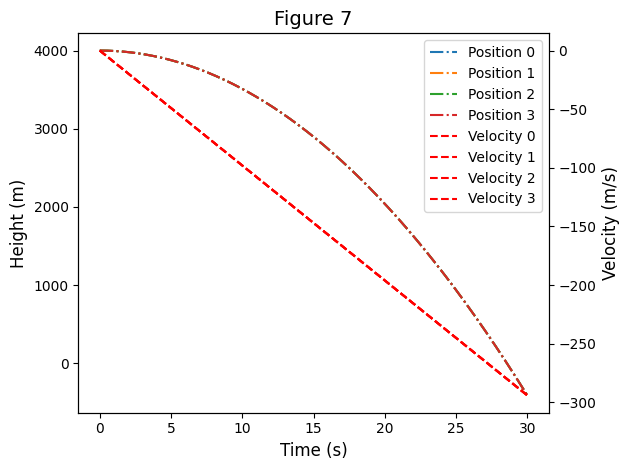

In [10]:
def derivatives(t,s,n):
    r,v = s # y is the position, v is velocity
    drdt = v 
    dvdt = -g_force(r,n) # new force depends on y
    return [drdt, dvdt]




t0, tf = (0,30) # go past 28 to include when it hits the bottom

t_eval = np.linspace(t0,tf, 1000)

y0 = [earth_rad,0]

def stopping(t,s,n): # stops at r = 0, won't happen for this time interval
    return s[0]

def solns_finder(n_vals): # iterates over n vals to create an array of solutions for each n
    solns = []
    for i in range(len(n_vals)):
        soln = solve_ivp(fun = derivatives, t_span = (t0,tf), y0 = y0, events = stopping, t_eval = t_eval, args = (n_vals[i],))
        solns.append(soln)
    return solns

solns = solns_finder(n_vals)




fig, ax  = plt.subplots()
ax2 = ax.twinx()
for i in range(len(n_vals)): # unpacks solution array to iteratively plot p and v vs t
    ax.plot(solns[i].t, solns[i].y[0] - earth_rad + 4000, ls = '-.', label = f"Position {i}")
    ax2.plot(solns[i].t,solns[i].y[1], color = 'red', ls = '--', label = f"Velocity {i}")
ax2.set_ylabel("Velocity (m/s)", fontsize = 12)
ax.set_xlabel("Time (s)", fontsize = 12)
ax.set_ylabel("Height (m)", fontsize = 12)
ax.set_title("Figure 7", fontsize = 14)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
fig.tight_layout()
plt.savefig('Fig7.png')


### 4.

In [11]:
def derivatives(t,s,n):
    r,v = s # y is the position, v is velocity
    drdt = v 
    dvdt = -g_force(r,n) # new force depends on y
    return [drdt, dvdt]




t0, tf = (0,1e4) # now we go to larger times to ensure we hit r = 0

t_eval = np.linspace(t0,tf, 1000)

y0 = [earth_rad,0]

def stopping(t,s,n):
    return s[0]

def solns_finder(n_vals):
    solns = []
    for i in range(len(n_vals)):
        soln = solve_ivp(fun = derivatives, t_span = (t0,tf), y0 = y0, events = stopping, t_eval = t_eval, args = (n_vals[i],))
        solns.append(soln)
    return solns

solns = solns_finder(n_vals)

for i in range(len(n_vals)):  # unpacks solution array to obtain event times, positions, velocities for each n
    print(f"The center time for n = {n_vals[i]} was {solns[i].t_events[0][0]:.3f} s.")
    print(f"The central velocity for n = {n_vals[i]} was {solns[i].y_events[0][0][1]:.3f} m/s.")

The center time for n = 0 was 1267.241 s.
The central velocity for n = 0 was -7905.971 m/s.
The center time for n = 1 was 1096.891 s.
The central velocity for n = 1 was -10435.239 m/s.
The center time for n = 2 was 1035.139 s.
The central velocity for n = 2 was -12200.746 m/s.
The center time for n = 9 was 943.875 s.
The central velocity for n = 9 was -18391.997 m/s.


## Part 6: A lunar mine shaft

In [12]:
moon_rad = 1738.1E3 # moon radius
moon_mass = 7.35E22 # moon mass

g_0 = scipy.constants.G*moon_mass/(moon_rad**2) # generates g value for moon

def derivatives(t,s):
    y,v = s # y is the position, v is velocity
    dydt = v 
    dvdt = -g_0*(y/moon_rad) # new force depends on y
    return [dydt, dvdt]

def stopping(t,s):
    return s[0] 


t0, tf = (0,10000) # want to ensure r = 0

t_eval = np.linspace(t0,tf, 1000)

y0 = [moon_rad,0]

soln = solve_ivp(fun = derivatives, t_span = (t0,tf), y0 = y0, t_eval = t_eval, events = stopping)

t = soln.t
y = soln.y[0]
v = soln.y[1]

print(f"It takes {soln.t_events[0][0]:.3f} s to reach the center, at speed {np.abs(soln.y_events[0][0][1]):.3f} m/s.")

moon_density = moon_mass/(4*np.pi*((moon_rad)**3)/3) # mass/volume
earth_density = earth_mass/(4*np.pi*((earth_rad)**3)/3)

T_crossing_moon = soln.t_events[0][0]

density_ratio = moon_density/earth_density

print(f"The moon's density is: {moon_density:.3f} kg/m^3, which is {density_ratio:.3f} of Earth's density.")

It takes 1624.906 s to reach the center, at speed 1679.949 m/s.
The moon's density is: 3341.754 kg/m^3, which is 0.608 of Earth's density.


In [13]:
# Solved on paper: T = (1/4)*sqrt(3pi/G)*(density)^(-1/2)
# You can solve it by setting finding the equation for the orbital period
# in terms of M and R, and then manipulating the expression to turn
# M and R^3 into a density. Finally, T/4 gives the crossing time.

def crossing_time(d):
    return (1/4)*np.sqrt(3*np.pi/scipy.constants.G)*(d**(-1/2)) 

print(f"Crossing Times:")
print(f"earth, formula: {crossing_time(earth_density)} s")
print(f"moon, solve_ivp: {T_crossing_moon} s")
print(f"moon, formula: {crossing_time(moon_density)} s")

Crossing Times:
earth, formula: 1267.342799918946 s
moon, solve_ivp: 1624.9059919736474 s
moon, formula: 1625.1201867414666 s
